In [1]:
import numpy as np
import matplotlib.pyplot as plt
seed = 1923
print (f"User seed is set to {seed}")

User seed is set to 1923


In [2]:
print ("""Make sure to check later which 
    functions you can use and which you have to write yourself""")
print ("\n")

print ("Question: can we use np arrays for division etc?")

Make sure to check later which 
    functions you can use and which you have to write yourself


Question: can we use np arrays for division etc?


# Question 1 Preparing some useful routines

In [3]:
def fac(k):
    """Returns factorial of k. Note: 0! is defined as 1"""
    if k == 0:
        return 1
    ans = k
    for x in range(1,k):
        ans *= x
    return ans

In [4]:
def poisson_probability(k,lambd):
    """
    Returns the Poisson probability, i.e., the probability of 'k' 
    occurences if 'lambd' is the occurence rate, per interval. 
    """
    return (lambd**k * np.exp(-1*lambd))/(fac(k))

## Output $P_{\lambda}(k)$ to at least 6 significant digits for following values

In [5]:
# Output P_{\lambda}(k) to at least 6 significant digits for these values
lambdas = [1,5,3,2.6]
ks = [0,10,20,40]

for k, lambd in zip(ks, lambdas):
    print(f'P_{lambd}({k}) = {poisson_probability(k,lambd):.5e}')


P_1(0) = 3.67879e-01
P_5(10) = 1.81328e-02
P_3(20) = 7.13538e-11
P_2.6(40) = 3.61512e-33


### Write a random number generator that returns a random floating-point number between 0 and 1. At minimum, use some combination of an (M)LCG and a 64-bit XOR-shift

In [6]:
class RandomGenerator(object):
    """
    Random generator should be an object because it maintains
    internal state between calls.
    """
    def __init__(self, seed):
        # make sure the everyhing is an unsigned 64 bit integer
        dtyp = np.uint64
        # the seed
        self.X = dtyp(seed)
        self.max_value = dtyp(2**64 - 1)
        
        # LCG values from Numerical Recipies
        self.a = dtyp(1664525)
        self.c = dtyp(1013904223)
        self.m = dtyp(2**32)
        
        # 64 bit XOR shift values from Numerical Recipies
        self.a1, self.a2, self.a3 = dtyp(21), dtyp(35), dtyp(4)
        
    def lincongen(self, X):    
        return (self.a*X+self.c) % self.m

    def XORshift64(self, X):
        if X == 0:
            raise ValueError("Seed cannot be zero")
        X = X ^ (X >> self.a1)
        X = X ^ (X << self.a2)
        X = X ^ (X >> self.a3)
        
        return X
    
    def get_randomnumber(self):
        """
        Combine LCG and XORshift to produce random float 
        between 0 and 1
        """
        self.X = self.lincongen(self.X)
        self.X = self.XORshift64(self.X)
        
        return self.X/self.max_value
    
        


In [7]:
RNGESUS = RandomGenerator(seed=seed)

/data1/osinga/miniconda/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ulong_scalars


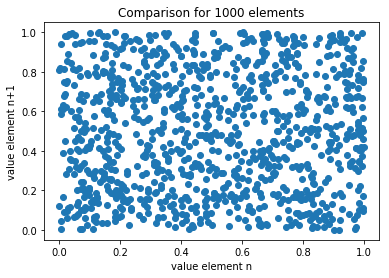

In [8]:
all_randnum = []
for i in range(1000):
    # Could vectorize? 
    all_randnum.append(RNGESUS.get_randomnumber())
    
plt.plot(all_randnum,np.roll(all_randnum,1),'o')
plt.title(f'Comparison for {len(all_randnum)} elements')
plt.xlabel('value element n')
plt.ylabel('value element n+1')
plt.savefig('q1b1.png')
plt.show();

/data1/osinga/miniconda/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ulong_scalars


Is np.linspace allowed?


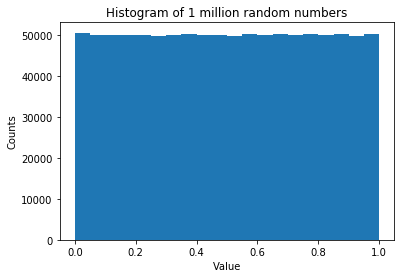

In [9]:
all_randnum = []
for i in range(int(1e6)):
    all_randnum.append(RNGESUS.get_randomnumber())
    
print( "Is np.linspace allowed?" )
plt.hist(all_randnum,bins=np.linspace(0,1,21))
plt.title(f'Histogram of 1 million random numbers')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.savefig('q1b2.png')
plt.show();

# Question 2

In [10]:
# Randomly generate a,b,c within asked bounds
a = RNGESUS.get_randomnumber()*(2.5-1.1) + 1.1
b = RNGESUS.get_randomnumber()*(2.0-0.5) + 0.5
c = RNGESUS.get_randomnumber()*(4-1.5) + 1.5

print (f'a, b, c = {a,b,c}')

a, b, c = (2.4502822156104314, 1.1334312980364027, 1.5995012866161997)


/data1/osinga/miniconda/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ulong_scalars


In [11]:
def numbdensprofile(x, a, b, c, A=1, Nsat = 100):
    """
    Returns the number density profile from the assignment
    
    a controls small-scale slope
    b contols transition scale
    c controls steepness of exponential dropoff
    """
    
    return A*Nsat * (x/b)**(a-3) * np.exp(-(x/b)**c)

In [12]:
def trapezoid(func,lbound,ubound,N=100,lb_open=False,ub_open=False):
    """
    Calculate the integral of a function using the trapezoid rule
    with equal spaced abscissae
    
    func    -- def   -- function which gives the y values
    lbound  -- float -- lower bound of integral
    ubound  -- float -- upper bound of integral
    N       -- int   -- number of abscissae
    lb_open -- bool  -- whether to include lower bound
    ub_open -- bool  -- whether to include upper bound
    
    """
    xvalues = np.linspace(lbound,ubound,N)
    delta_x = (ubound-lbound)/(N-1)    
    
    if lb_open: # skip lower bound, start at x1
        start_midpoint = 2
        integral = func(xvalues[1])*3/2
        
    else: # dont skip lower bound, start at x0
        integral = func(lbound)/2       
        start_midpoint = 1
    
    if ub_open:
        end_midpoint = -2
    else:
        end_midpoint = -1
    
    # all middle points
    for x in xvalues[start_midpoint:end_midpoint]:
        integral += func(x)
    
    if ub_open:
        integral += func(xvalues[-2])*(3/2)
    else: 
        integral += func(xvalues[-1])/2
        
    integral *= delta_x
    
    return integral
    

In [13]:
def extended_midpoint(func,lbound,ubound,N=100):
    delta_x = (ubound-lbound)/(N-1)    
    # Equally spaces x values at the midpoints
    xvalues = np.arange(lbound+delta_x,ubound-delta_x,delta_x)
    
    # all points
    integral = 0
    for x in xvalues:
        integral += func(x)
    
    integral *= delta_x
    
    return integral

In [14]:
def romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae
    
    efficiency:
    http://homen.vsb.cz/~lud0016/NM/Lecture_Notes_10-Romberg_Integration.pdf
    
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = np.linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = np.linspace(lbound,ubound,2**i+1)
        # add new points to the integral (om en om, starting from 1)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # columns
        for i in range(j,order): # rows
            #print (i,j)
            #print (f'{4**j}*S{i},{j-1} - S{i-1},{j-1} / {4**j} - 1' )
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j -1)

    # compare this for the error function with the slides. 
    # print (all_S)
    
    return all_S[order-1,order-1]
        


In [15]:
def extended_romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with extended midpoints
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae
    
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)/2
    # just the first midpoint
    points = np.array([ubound+delta_x])
    npoints = points
    integral = delta_x * func(points)
    
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        npoints *= 3
        delta_x = (ubound-lbound)/(npoints+1)
        # add points in the middle
        points = np.linspace(lbound+delta_x,ubound-delta_x,npoints)
        # add new points to the integral (om en om, starting from 0)
        integral = 0.5*integral + delta_x * np.sum(func(points[0::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # columns
        for i in range(j,order): # rows
            #print (i,j)
            #print (f'{4**j}*S{i},{j-1} - S{i-1},{j-1} / {4**j} - 1' )
            all_S[i,j] = (9*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           8)

    # compare this for the error function with the slides. 
    # print (all_S)
    
    return all_S[order-1,order-1]

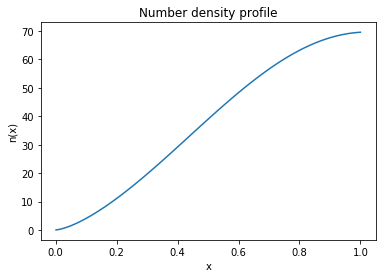

We see that it blows up near x=0, so simple trapezoid does not work:
84.53012433793573
Romberg doesnt work either:
84.50431143170788
Extended midpoint (best one):
84.49185105353793
Extended Romberg:
84.44131503459693


/data1/osinga/miniconda/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [22]:
# For 
# a, b, c = (2.4545593364474785, 1.2954526977495828, 2.700255764586844)
a = 2.45#45593364474785
b = 1.29#54526977495828
c = 2.70#0255764586844

# WolframAlpha input:
# integrate ( 100 * (x/b)**(a-3) * exp(-(x/b)**c)  ) from 0 to 5 where a = 2.4545593364474785, b = 1.2954526977495828, c = 2.700255764586844

xs = np.linspace(0.001,1,100)
plt.plot(xs, xs**2*numbdensprofile(xs, a, b, c))
plt.title('Number density profile')
plt.xlabel('x')
plt.ylabel('n(x)')
plt.show();
print ("We see that it blows up near x=0, so simple trapezoid does not work:")

# integral is only a function of R so add the prefactor manually
prefactor = 4*np.pi # integral over theta and phi
print (trapezoid(lambda x:  x**2*numbdensprofile(x, a, b, c)
                 , 0, 5,N=100,lb_open=True))

print ("Romberg doesnt work either:")
print (romberg(lambda x: x**2*numbdensprofile(x, a, b, c), 1e-5, 5))

print ("Extended midpoint (best one):")
print (extended_midpoint(lambda x: x**2*numbdensprofile(x,a,b,c)
                         ,0,5,N=100))

print ("Extended Romberg:")
print (extended_romberg(lambda x: x**2*numbdensprofile(x, a, b, c)
                        , 0, 5,order=10))



In [21]:
# Randomly generate a,b,c within asked bounds
a = RNGESUS.get_randomnumber()*(2.5-1.1) + 1.1
b = RNGESUS.get_randomnumber()*(2.0-0.5) + 0.5
c = RNGESUS.get_randomnumber()*(4-1.5) + 1.5

print ("For the following ")
print (f'a, b, c = {a,b,c}')

print ("Extended midpoint rule gives:")
A = 1 / ( extended_midpoint(lambda x: x**2*numbdensprofile(x,a,b,c)
                         ,0,5,N=100))
print (f"A = {A}")

For the following 
a, b, c = (1.8338021660571773, 1.6644788732039735, 2.2365063170469224)
Extended midpoint rule gives:
A = 0.004246393341992151


/data1/osinga/miniconda/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ulong_scalars
